In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from IPython import display
import os
from os import listdir
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings 
warnings.filterwarnings("ignore")

### Read and check the data if there are  null values and missing values or not

In [2]:
data = pd.read_csv("Data/chinese_mnist.csv")
data.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [3]:
data.info() #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


#### There are 15 unique characters and each character has 1000 images (more details below)

In [4]:
data["value"].nunique()

15

In [5]:
data.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

#### Checking missing value or data

In [6]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
suite_id,0,0.0
sample_id,0,0.0
code,0,0.0
value,0,0.0
character,0,0.0


### Read the image - After this scope we will have
- The listImageArray contains all the image that is display in array of (0, 1) -> this will be our input X of model
- The label_list contains the unique value that the image shows -> this will be our output y of model

#### Number of images in folder

In [7]:
image_files = list(listdir("Data/data"))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 15000


#### Take image file name

In [8]:
def image_files(x):
    file_name = "Data/data/"+ f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name
data["file"] = data.apply(image_files, axis=1)

#### Take image size

In [9]:
def image_sizes(file_name):
    image = plt.imread(file_name)
    return list(image.shape)

#### Combine to dataframe for easy look

In [10]:
image_size = np.stack(data['file'].apply(image_sizes))
image_size_df = pd.DataFrame(image_size,columns=['w','h'])
data_first = pd.concat([data,image_size_df],axis=1, sort=False)
data_first.head()

,suite_id,sample_id,code,value,character,file,w,h
0,1,1,10,9,九,Data/data/input_1_1_10.jpg,64,64
1,1,10,10,9,九,Data/data/input_1_10_10.jpg,64,64
2,1,2,10,9,九,Data/data/input_1_2_10.jpg,64,64
3,1,3,10,9,九,Data/data/input_1_3_10.jpg,64,64
4,1,4,10,9,九,Data/data/input_1_4_10.jpg,64,64


### Plot some images

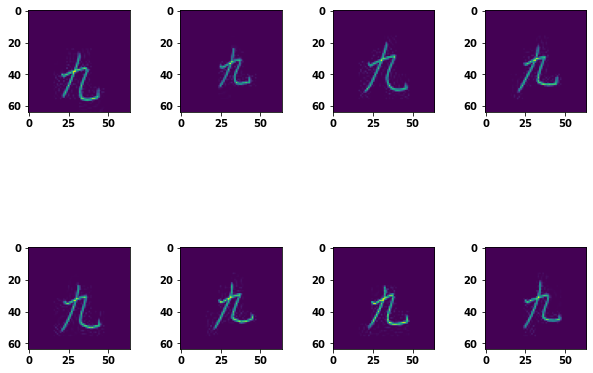

In [11]:
plt.figure(figsize = (10, 8))
for i in range(0, 8):
    plt.subplot(240 + i + 1)
    image = plt.imread(data_first["file"][i])
    plt.imshow(image)
plt.subplots_adjust(wspace = 0.5, hspace = 0.2)
plt.show()

### Take out the input and output

##### pip install scikit-image

In [12]:
import skimage.transform

def read_image(file_name):
    image = skimage.io.imread(file_name)
    return image

In [13]:
X = data['file'].apply(read_image).to_numpy()
y = data_first['value'].to_numpy()

In [14]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

### Flatten the image

In [15]:
lstImageFlatten = []
for i in range(0, X.shape[0]):
    lstImageFlatten.append(X[i].flatten()/255)
lstImageFlatten = np.array(lstImageFlatten)
list_image = lstImageFlatten

### Split data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(list_image, y_enc, test_size = 0.3, random_state = 35)

### Logistic Regression

In [17]:
logic = LogisticRegression(penalty ='l1', multi_class = 'multinomial', solver = "saga")

In [18]:
logic.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

In [19]:
logic.score(X_train, y_train) * 100

65.42857142857143

In [20]:
logic.score(X_test, y_test) * 100

48.13333333333333

#### Seems quite low with this kind of models, now we try SVC. After that we will use PCA then apply agian these two models because these two may  are the best when dealing with multi-class classification

### SVC

In [21]:
svc = SVC()

In [22]:
svc.fit(X_train, y_train)

SVC()

In [23]:
svc.score(X_train, y_train) * 100

88.84761904761905

In [24]:
svc.score(X_test, y_test) * 100

71.44444444444444

In [25]:
models = [
    LogisticRegression(),
    SVC()
]

In [29]:
import datetime
df = {
    'Model name':[],
    'Acurracy Train':[],
    'Acurracy Test':[],
    'Duration':[],
}
for model in models:
    clf = model
    name = model.__class__.__name__
    
    start = datetime.datetime.now()
    clf.fit(X_train, y_train)
    train_acur = clf.score(X_train, y_train)
    test_acur= clf.score(X_test, y_test)
    end = datetime.datetime.now()
    duration = end - start
    
    df['Model name'].append(name)
    df['Acurracy Train'].append(train_acur)
    df['Acurracy Test'].append(test_acur)
    df['Duration'].append(duration)

#### The SVC seems more ways better however it still take a very long time about 15 - 30 minutes. So now we use PCA to reduce the time and may be increase some accurancy

### Using PCA to reduce the shape of the image 
- First try to keep 3000 components
- Fit the data 
- Plot elbow graph to choose less components than first choices

Text(0, 0.5, 'Explained variance')

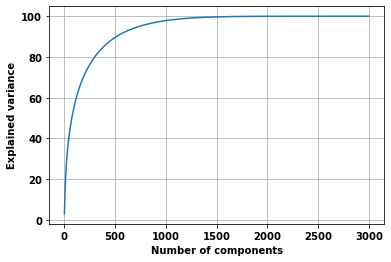

In [30]:
pca = PCA(n_components = 3000 )
pca.fit(list_image)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

- With the elbow graph we could see that the saturation of the image explained variance is about 1000 to 1500.
- In this notebook i choose 1200 because at that point the saturation has already started.

In [31]:
pca_reduced = PCA(n_components = 1200 )
pca_reduced.fit(list_image)
list_image = pca_reduced.transform(list_image)

## Models, accurancy, train, test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(list_image, y_enc, test_size = 0.3, random_state = 35)

### SVC Classification

In [33]:
svc = SVC()

In [34]:
svc.fit(X_train, y_train)

SVC()

In [35]:
svc.score(X_train, y_train)

0.9007619047619048

In [36]:
svc.score(X_test, y_test)

0.7224444444444444

#### The SVC acurancy seems good enough for this kind of data set about 72% in test data and approximately 90% for the train data 

### Logistic Regression

In [37]:
logic = LogisticRegression(penalty ='l1', multi_class = 'multinomial', solver = "saga")

In [38]:
logic.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

In [39]:
logic.score(X_train, y_train)

0.6446666666666667

In [40]:
logic.score(X_test, y_test)

0.49333333333333335

#### The logicstic models seem not fit for this kind of data, the best train about 65 - 70 % and the best test just about 50%

In [41]:
models = [
    LogisticRegression(),
    SVC()
]

In [42]:
df = {
    'Model name':[],
    'Acurracy Train':[],
    'Acurracy Test':[],
    'Duration':[],
}
for model in models:
    clf = model
    name = model.__class__.__name__
    
    start = datetime.datetime.now()
    clf.fit(X_train, y_train)
    train_acur = clf.score(X_train, y_train)
    test_acur= clf.score(X_test, y_test)
    end = datetime.datetime.now()
    duration = end - start
    
    df['Model name'].append(name)
    df['Acurracy Train'].append(train_acur)
    df['Acurracy Test'].append(test_acur)
    df['Duration'].append(duration)

In [45]:
df

{'Model name': ['LogisticRegression', 'SVC'],
 'Acurracy Train': [0.7026666666666667, 0.9007619047619048],
 'Acurracy Test': [0.4882222222222222, 0.7224444444444444],
 'Duration': [datetime.timedelta(seconds=5, microseconds=30235),
  datetime.timedelta(seconds=305, microseconds=398689)]}

## Conclusion:
- After PCA the models run faster and some the accurancy better 1-2%
- We know that we just need 1200 coponents of the pictures to run the SVC model not all the components
- We can eluvate the model by select again the parameters or change to deep learning which is more suitble when we are dealing with image dataset classification